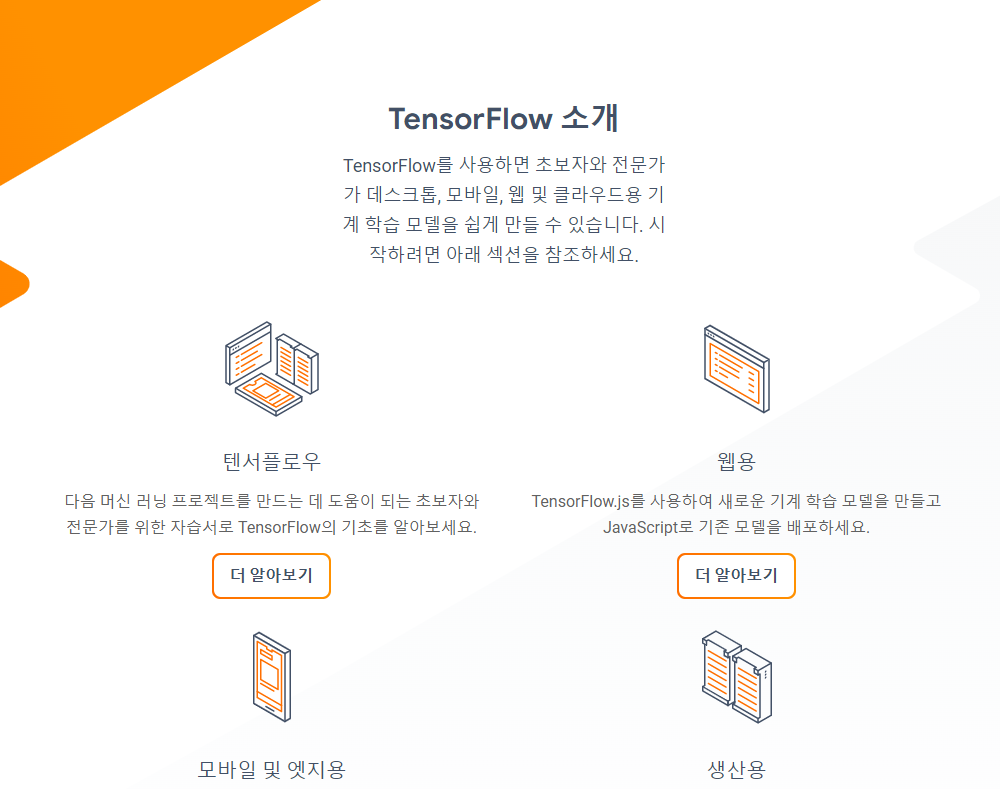

In [1]:
#!pip show tensorflow

In [2]:
# 텐서플로우 설치(없는 경우)
#!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.



     ---------------------------------------- 61.0/61.0 kB ? eta 0:00:00
   --------------------------------------- 376.9/376.9 MB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 3.0/3.0 MB 19.0 MB/s eta 0:00:00
   ---------------------------------------- 26.4/26.4 MB 20.5 MB/s eta 0:00:00
   ---------------------------------------- 127.7/127.7 kB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 15.8/15.8 MB 17.7 MB/s eta 0:00:00
   ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
   --------------------------------------- 413.4/413.4 kB 13.0 MB/s eta 0:00:00
   ---------------------------------------- 5.5/5.5 MB 17.5 MB/s eta 0:00:00
   ---------------------------------------- 4.1/4.1 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 1.5/1.5 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: proto

In [3]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

C:\Users\LG\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 데이터 준비
- 케라스에서 제공하는 MNIST패션 데이터 로딩
- 훈련세트와 테스트세트를 나누어 반환하므로 그에 맞춰서 대입
- train_test_split과 결과가 다르니 주의

In [4]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = \
                                    keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 데이터 확인

In [5]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [6]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

##### 확인
- 총 60000개의 이미지 데이터셋
- 각 이미지는 28x28 크기
- 테스트 세트는 동일한 형태로 10000개의 이미지가 존재

#### 데이터를 출력하여 이미지로 확인 

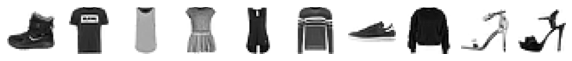

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(X_train[i], cmap='gray_r')
    axs[i].axis('off')
plt.show()

#### 샘플들의 타겟 값 확인
0: 티셔츠  
1: 바지  
2: 스웨터  
3: 드레스  
4: 코트  
5: 샌들  
6: 셔츠  
7: 스니커즈  
8: 가방  
9: 앵클 부츠  

In [8]:
[y_train[i] for i in range(10)]

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]

In [9]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

- 각 아이템마다 6000개의 샘플이 들어있음을 확인

### 로지스틱 회귀를 이용하여 패션 아이템 분류하기
- 훈련 샘플의 개수가 많으므로 한 번에 훈련하는 것보다 샘플을 하나씩 이용하여 훈련하는 것이 효율적으로 보임
- 확률적 경사 하강법을 이용하는 것이 알맞아 보임
- SGDClassifier를 이용
    - 확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향으로 이동함
    - 특성마다 범위가 다르면 손실 함수의 경사를 내려오는 것이 문제가 생길 수 있음
    - 현재 데이터는 각 픽셀이 0 ~ 255 사이의 정수값을 가지므로 255로 나누어 0~1사이의 값으로 정규화 적용
    - 표준화는 아니지만 양수 값으로 이루어진 데이터를 전처리할 때 많이 활용하는 기법

In [10]:
X_train_scaled = X_train / 255.0
X_train_scaled

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [11]:
X_train_scaled = X_train / 255.0
X_train_scaled = X_train_scaled.reshape(-1, 28*28) # 1차원으로 변경

In [12]:
X_train[0], X_train_scaled[0]

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
           1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
           0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
           0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
           0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
          10

In [13]:
X_train_scaled.shape

(60000, 784)

##### 결과
- 784개의 픽셀로 이루어진 사진 데이터가 60000개 준비됨

### SGDClassifier를 이용하여 교차검증을 통해 성능 확인

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

# 사이킷런 1.1 버전에서는 SGDClassifier의 loss 매개변수 중 
# 로지스틱 손실을 의미하는 'log'가 'log_loss'로 바뀐다는 경고가 발생
# 사이킷런 1.1 이상을 사용하는 경우 loss='log'를 loss='log_loss'로 변경해야 함
sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)

scores = cross_validate(sc, X_train_scaled, y_train, n_jobs=-1)
print(np.mean(scores['test_score']))

nan


C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "C:\Users\LG\anaconda3\lib\site-packa

In [15]:
# max_iter=10
sc = SGDClassifier(loss='log_loss', max_iter=10, random_state=42)

scores = cross_validate(sc, X_train_scaled, y_train, n_jobs=-1)
print(np.mean(scores['test_score']))

nan


C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "C:\Users\LG\anaconda3\lib\site-packa

In [16]:
# max_iter=20
sc = SGDClassifier(loss='log_loss', max_iter=20, random_state=42)

scores = cross_validate(sc, X_train_scaled, y_train, n_jobs=-1)
print(np.mean(scores['test_score']))

nan


C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "C:\Users\LG\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "C:\Users\LG\anaconda3\lib\site-packa

##### 결과
- SGDClassifier의 max_iter값을 조정하여 반복 횟수를 증가시켜도 성능 향상폭이 크지 않음

##### 성능 향상을 위한 고민
- 선형 회귀와 동일한 선형 방정식으로 학습  
    - $z = a \times (weight) + b \times (length) + c \times (diagonal) + d \times (deight) + e \times (width) + f$
- 패션 데이터에 맞추어 변경하면
    - $z\_티셔츠 = w1 \times (픽셀1) + w2 \times (픽셀2)\ +\ ...\ + w784 \times (픽셀784) + b$
    - 총 784개의 픽셀이므로 길이가 긴 식이 만들어짐
- 바지 데이터에 대한 방정식은
    - $z\_바지 = w1' \times (픽셀1) + w2' \times (픽셀2)\ +\ ...\ + w784' \times (픽셀784) + b'$
    - 티셔츠에 대한 방정식과 비슷하지만 가중치와 절편은 다른 값을 사용(그렇지 않으면 바지와 티셔츠 구분 불가)
- 위와 같은 방식으로 나머지 클래스에 대한 방정식이 만들어진다고 이해할 수 있음
- SGDClassifier 모델은 MNIST데이터의 클래스를 구분하기 위해 10개의 방정식에 대한 모델 파라미터(가중치와 절편)를 찾음
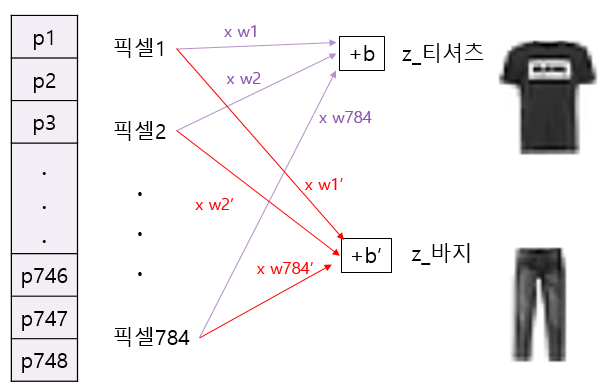
- 방정식을 계산한 후 소프트맥스 함수를 통과하여 각 클래스에 대한 확률을 얻음

# 인공신경망
- 1943년 워런 매컬러와 월터 피츠가 제안한 뉴런 모델(매컬러-피츠 뉴런)
- 다음 그림과 같은 인간의 뇌 동작을 표현하기 위해 만들어짐
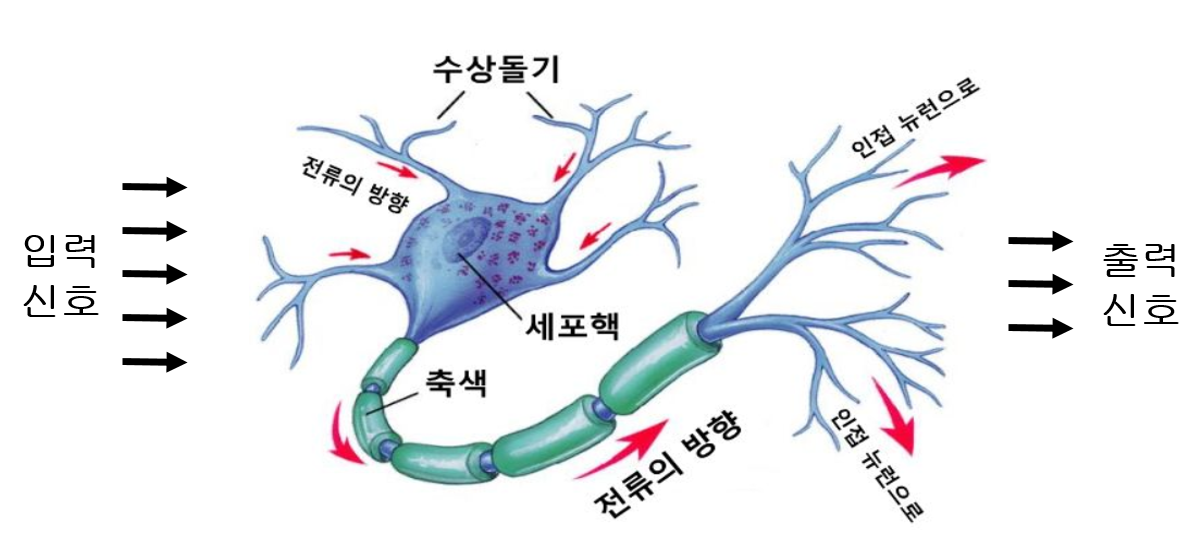

## 생물학적 뉴런의 동작
- 입력은 수상돌기를 통해 들어옴(다수)
- 축색(축삭)을 통해 출력으로 내보낸다(단수)
- 다른 뉴런으로부터 전달받은 입력은 수상돌기로 연결되어 덧셈을 진행
- 입력은 합산되어 출력통로인 축색으로 출력(0 or 1)
- 합친 값이 어떤 설정치(임계값) 이상이면 출력되고 그 이하인 경우 출력 없음(역치값. threshold)
- 뉴런과 뉴런은 시냅스로 연결되어 있음
- 연결된 다음 뉴런을 억제할 것인지 흥분시킬 것인지 두 가지 동작을 함
- 시냅스의 전기적 신호는 이온을 사용

## 인공 신경망 활용
- 이미지 분류 문제에는 인공 신경망(딥러닝)이 알맞은 경우가 많음
- 가장 기본적인 인공 신경망의 형태는 확률적 경사하강법을 사용하는 로지스틱 회귀를 기반으로 함
- 패션 아이템 분류 문제를 인공 신경망으로 표현하면 다음과 같음
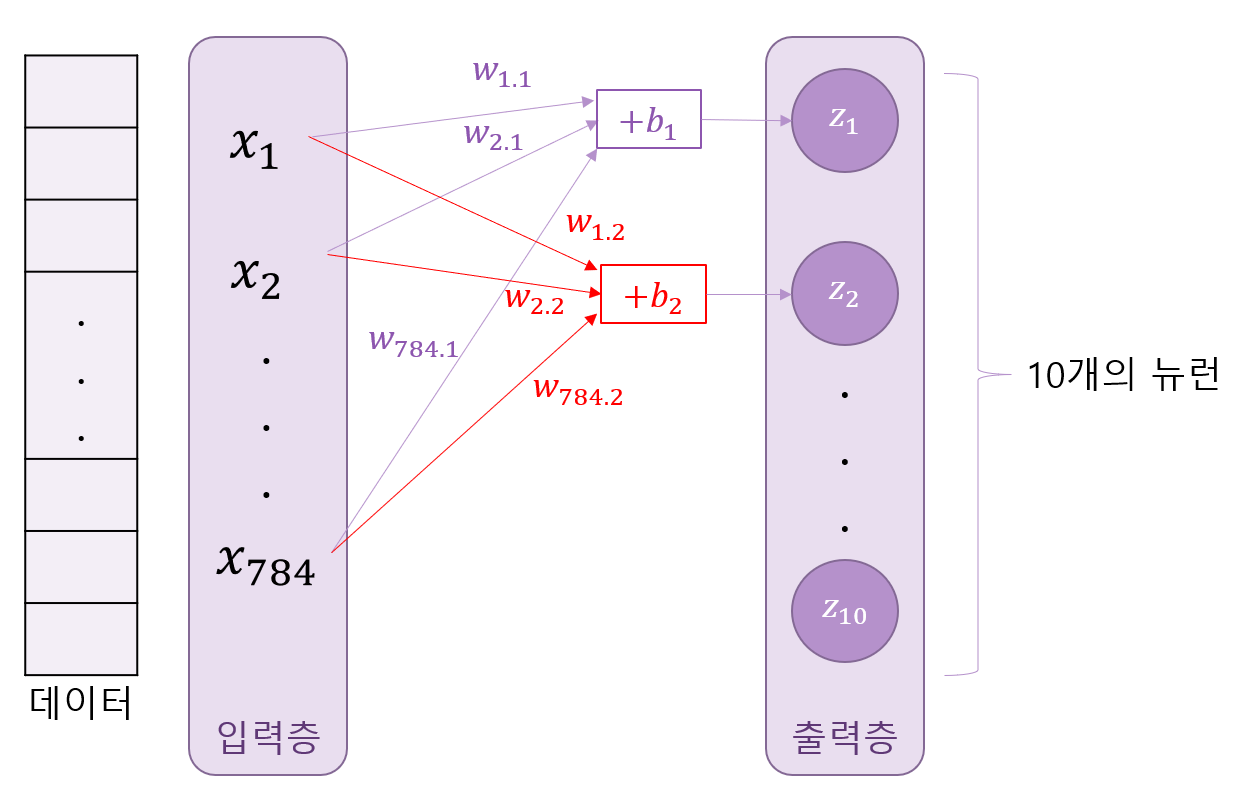
- 784개의 픽셀 하나 하나($x_1$ ~ $x_{784}$)를 나타내는 입력층
- 총 10개의 클래스를 예측($z_1$ ~ $z_{10}$)하는 출력층
- z값을 계산하는 단위를 표현하는 용어(뉴런, 유닛)
- 각 픽셀에 곱해지는 가중치 $w_{1.1}$, $w_{1.2} ...$
- 절편은 뉴런마다 하나씩 $b_1$ ~ $b_{10}$으로 나타냄

### 생물학적 뉴런과 인공 신경망의 차이
- 생물학적 뉴런은 가중치와 입력을 곱하여 출력을 만드는 동작을 하지는 않음(소프트맥스 X, 시그모이드 X)
- 인공 신경망은 생물학적 뉴런의 모양을 본뜬 수학적 모델임(실제 생물학적 뉴런의 동작은 아직 알 수 없는 부분이 많음)
- 인공 신경망이나 AI라는 개념이 실제 사람의 뇌와 같다는 생각은 잘못된 것
- 기존 머신러닝 알고리즘으로 해결하기 어려웠던 문제를 해결하기 위한 새로운 머신러닝 알고리즘 개념

## 텐서플로우와 케라스
### 텐서플로(Tensorflow)
- 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리
- 코랩을 이용하는 경우 바로 사용 가능
- 직접 사용하려는 경우 설치 필요
- 딥러닝 라이브러리는 GPU사용 가능(GPU는 벡터와 행렬 연산에 최적화된 장치)
- 텐서플로는 저수준 API와 고수준 API(Keras) 지원

### 케라스(Keras)
- 직접 GPU연산을 하지 않고 GPU연산을 수행하는 백엔드 라이브러리(텐서플로, 씨아노, CNTK 등)를 사용
- 멀티-백엔드 케라스라고 부르며 이는 케라스를 통해 다양한 백엔드 딥러닝 라이브러리를 사용할 수 있음을 의미
- 직관적으로 사용하기 편한 고수준 API를 제공
- 현재는 텐서플로우 라이브러리에 케라스 API가 내장됨(tensorflow 2.0+)
- 텐서플로우의 핵심 API이며 멀티-백엔드 케라스는 2.3.1이루 개발 중지됨(텐서플로 == 케라스)

### 인공 신경망으로 모델 만들기
#### 텐서플로에서 케라스 사용을 위한 임포트 선언

In [32]:
import tensorflow as tf
from tensorflow import keras

#### 데이터 준비
- 교차검증을 사용하지 않는 이유
    - 딥러닝 분야의 데이터셋은 데이터 양이 충분하기 때문에 검증 점수가 안정적임
    - 데이터 양이 많으므로 훈련 시간이 많이 필요함(몇 시간 내지 며칠 등의 시간이 필요할 수 있음)

In [33]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = \
                                    keras.datasets.fashion_mnist.load_data()
X_train_scaled = X_train / 255.0
X_train_scaled = X_train_scaled.reshape(-1, 28*28) # 1차원으로 변경

from sklearn.model_selection import train_test_split

X_train_scaled, X_test_val_scaled, y_train, y_test_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

#### 훈련 세트 크기 확인

In [34]:
X_train_scaled.shape, y_train.shape

((48000, 784), (48000,))

#### 검증 세트 크기 확인

In [35]:
X_test_val_scaled.shape, y_test_val.shape

((12000, 784), (12000,))

#### 인공 신경망에서 오른쪽 출력층 생성
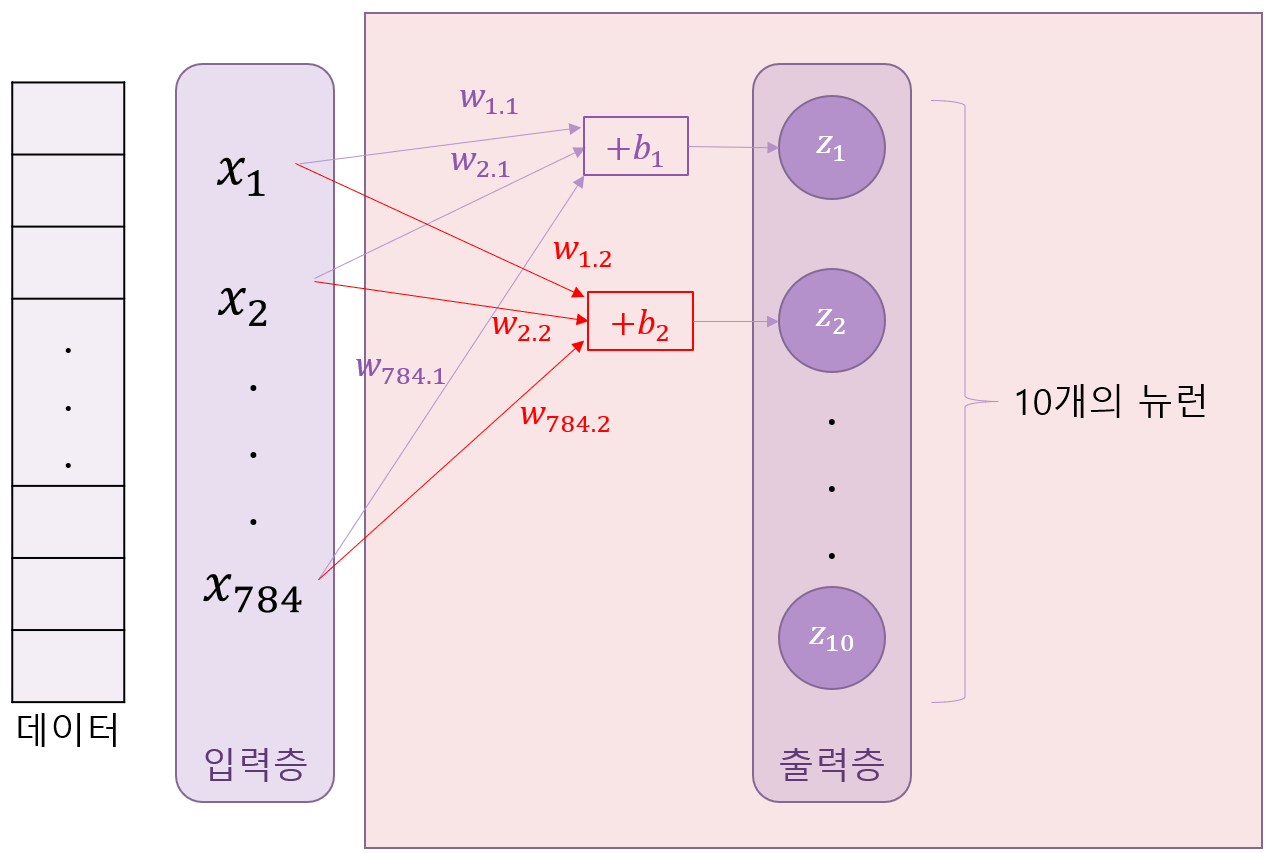
- 케라스의 레이어 패키지 사용
- 밀집층(dense layer)이 가장 기본이 됨
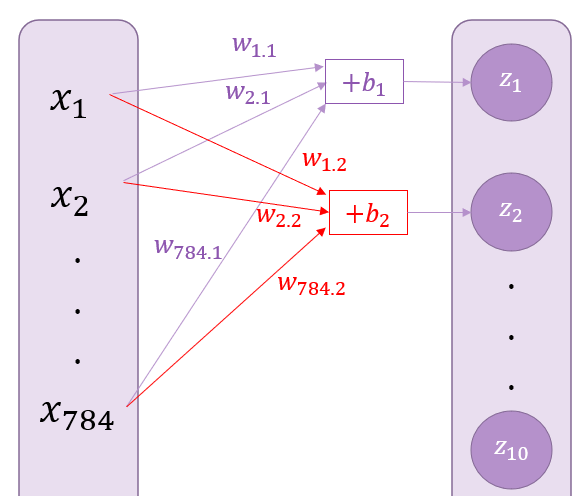
- 위와 같이 연결된 형태를 밀집이라고 표현
- 모든 뉴런이 연결하고 있으므로 완전 연결층(fully connected layer)이라고 부르기도 함
- 케라스의 Dense 클래스를 이용하여 밀집층 생성
    - units=10 :뉴런의 개수 매개변수
    - activation='softmax' :뉴런의 출력에 적용할 함수(이진 분류라면 'sigmoid')
    - input_shape=(784,) :입력의 크기

#### 밀집(dense)층 생성

In [36]:
from tensorflow.keras.layers import Dense

dense = Dense(10, activation='softmax')

In [37]:
from tensorflow.keras.models import Sequential

model = keras.Sequential() # 모델 생성

In [38]:
from tensorflow.keras.layers import Input

input_layer = Input(shape=(784,)) # 입력층 생성
model.add(input_layer) # 모델에 입력층 추가

#### 밀집층을 가진 신경망 모델 생성
- Sequantial 클래스로 객체 생성
- 만들어진 Sequential객체는 신경망 모델
- 모델에 layer(입력-은닉-출력)을 추가하여 신경망 모델을 구성

In [39]:
model.add(Dense(10, activation='softmax'))

#### 만들어진 신경망 모델 개념
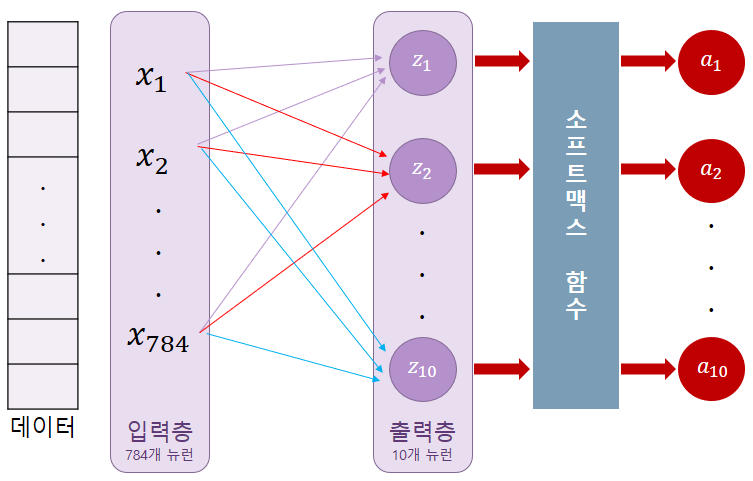
- 입력층과 출력층 사이에 연결선을 제외하고 가중치와 절편은 표시하지 않음
- 그림으로 표현하지는 않았지만 절편이 뉴런마다 더해진다는 것은 기본 개념
- 뉴런의 선형 방정식 결과에 적용되는 소프트맥스와 같은 함수를 활성화 함수(activation function)라고 함 
- 시그모이드 또는 소프트맥스 함수는 뉴런의 출력에 바로 적용되므로 층의 일부로 나타내기도 함

# 인공 신경망으로 패션 아이템 분류
- 사이킷런과 비교해 케라스에서 모델을 만드는 방식은 약간의 차이가 있음

## 케라스 모델 훈련 전 설정 단계
- model객체의 compile() 메서드 사용
- 손실 함수의 종류 지정은 필수
- 훈련 과정에서 계산하고자 하는 측정값을 지정

In [40]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### loss
- 이진분류는 이진 크로스 엔트로피 손실 함수 사용
    - 케라스에서 이진 분류 시 손실 함수: loss='binary_crossentropy'
- 다중 분류에서는 크로스 엔트로피 손실 함수 사용
    - 케라스에서 다중 분류 시 손실 함수: loss='categorical_crossentropy'
- sparse: 희소
- 텐서플로우에서는 타겟값을 원-핫 인코딩으로 바꾸지 않아도 바로 사용 가능
    - 정수로 된 타겟값을 이용하여 크로스 엔트로피 손실을 계산하는 경우 
    - loss='sparse_categorical_crossentropy'
    - 데이터의 타겟값이 원-핫 인코딩으로 되어 있다면 categorical_crossentropy로 지정

In [41]:
y_train[:10]

array([7, 3, 5, 8, 6, 9, 3, 3, 9, 9], dtype=uint8)

- 타겟값이 정수형이므로 sparse_categorical_crossentropy로 지정함

#### metrics
- 케라스는 모델이 훈련할 때 기본적으로 에포크마다 손실값을 출력
- 손실의 변화를 보면서 훈련이 잘되는 것인지 정확도를 출력할 수 있도록 지표를 지정할 때 사용
- 분류이므로 정확도 지표(accuracy)를 지정

#### 모델 훈련
- fit()메서드는 사이킷런과 유사함
- 처음 두 개의 매개변수에 입력데이터와 정답데이터를 지정
- epochs 매개변수로 반복할 에포크 횟수 지정

In [42]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 650us/step - accuracy: 0.7335 - loss: 0.7930
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.8338 - loss: 0.4857
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.8446 - loss: 0.4569
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.8503 - loss: 0.4427
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.8534 - loss: 0.4339


##### 결과
- 텐서플로는 랜덤하게 동작하는 특성이 있으므로 실행마다 약간씩 결과가 달라짐
- 모델 컴파일 시 지정한 metric에 따라 각 에포크 마다 결과를 보여줌

#### 모델 성능 평가
- 케라스에서 모델의 성능을 평가하는 메서드를 이용
- evaluate()

In [43]:
model.evaluate(X_test_val_scaled, y_test_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.8465 - loss: 0.4372


[0.4451083540916443, 0.847000002861023]

##### 결과
- 검증세트의 점수는 훈련세트 점수보다 조금 낮은 것이 일반적임
- 훈련세트 점수
    - accuracy: 0.8625
    - accuracy: 0.8637
    - accuracy: 0.8635
    - accuracy: 0.8652
    - accuracy: 0.8660
- 검증세트 점수
    - accuracy: 0.8517

---

In [44]:
X_train_scaled[3]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01176471,
       0.        , 0.        , 0.24313725, 0.36862745, 0.37647059,
       0.3254902 , 0.        , 0.        , 0.01176471, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01176471, 0.        , 0.        , 0.64705882,
       0.60784314, 0.18039216, 0.15686275, 0.33333333, 0.72156863,
       0.3372549 , 0.        , 0.00392157, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.        ,
       0.        , 0.74509804, 0.37647059, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.54509804, 0.36470

In [45]:
# 훈련데이터로 예측해보기
for i in range(10):
    y_pred = model.predict(X_train_scaled[i:i+1])
    print(f'정답:{y_train[i]}', end=', ')
    for j in range(10):
        if y_pred[0][j] == y_pred.max():
            print(f'예측:[{j}]')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
정답:7, 예측:[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
정답:3, 예측:[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
정답:5, 예측:[5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
정답:8, 예측:[8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
정답:6, 예측:[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
정답:9, 예측:[9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
정답:3, 예측:[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
정답:3, 예측:[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
정답:9, 예측:[9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
정답:9, 예측:[9]
